In [378]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [379]:
data = pd.read_csv("sound_features.csv")
df = pd.DataFrame(data, columns=["vol","pitch","tempo","beats","emotion","intensity"])

In [380]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)),int(0.8*len(df))])
print(train.shape)
print(test.shape)
print(valid.shape)

(864, 6)
(288, 6)
(288, 6)


C:\Users\callu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [381]:
def scale_set(data, oversample):
    x = np.hstack((data[data.columns[0:4]].values, np.reshape(data[data.columns[5]],(-1,1))))
    y = data[data.columns[4]].values
    
    scalar = StandardScaler()
    x = scalar.fit_transform(x)

    if oversample:
        ros = RandomOverSampler()
        x,y = ros.fit_resample(x,y)
    
    data = np.hstack((x, np.reshape(y,(-1,1))))

    return data, x, y


In [382]:
train, X_train, y_train = scale_set(train, True)
valid, X_valid, y_valid = scale_set(valid, False)
test, X_test, y_test = scale_set(test, False)
y_train -= 1
y_test -= 1

Random Forest Model

In [383]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [384]:
RFC_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
    )
RFC_model = RFC_model.fit(X_train, y_train)

In [385]:
y_pred = RFC_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.27      0.35      0.30        20
           1       0.46      0.47      0.46        34
           2       0.24      0.39      0.30        33
           3       0.28      0.23      0.25        35
           4       0.47      0.50      0.48        46
           5       0.34      0.23      0.28        48
           6       0.16      0.13      0.14        31
           7       0.32      0.29      0.31        41

    accuracy                           0.33       288
   macro avg       0.32      0.32      0.32       288
weighted avg       0.33      0.33      0.32       288



XGBoost

In [386]:
from xgboost import XGBClassifier

In [387]:
XGBC_model = XGBClassifier(
    n_estimators = 200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

In [388]:
XGBC_model.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [389]:
y_pred = XGBC_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.28      0.25      0.26        20
           1       0.38      0.41      0.39        34
           2       0.23      0.33      0.27        33
           3       0.16      0.14      0.15        35
           4       0.53      0.54      0.54        46
           5       0.33      0.23      0.27        48
           6       0.21      0.23      0.22        31
           7       0.28      0.27      0.28        41

    accuracy                           0.31       288
   macro avg       0.30      0.30      0.30       288
weighted avg       0.31      0.31      0.31       288



In [390]:
import tensorflow

In [391]:
y_train_cat = tensorflow.keras.utils.to_categorical(y_train)  
y_test_cat = tensorflow.keras.utils.to_categorical(y_test)
y_valid -= 1
y_valid_cat = tensorflow.keras.utils.to_categorical(y_valid)

In [392]:
nn_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(64, activation="relu"),
    tensorflow.keras.layers.Dropout(0.3),
    tensorflow.keras.layers.Dense(64, activation="relu"),
    tensorflow.keras.layers.Dropout(0.3),
    tensorflow.keras.layers.Dense(8,activation="softmax")
])

In [393]:
nn_model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss='categorical_crossentropy')

In [394]:
print(X_train.shape)
y_train_cat.shape

(1008, 5)


(1008, 8)

In [395]:
history = nn_model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_valid, y_valid_cat),
    verbose=1
)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0681 - val_loss: 2.0292
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9855 - val_loss: 1.9733
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9337 - val_loss: 1.9251
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8965 - val_loss: 1.8822
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8316 - val_loss: 1.8555
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8178 - val_loss: 1.8282
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7724 - val_loss: 1.8064
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7592 - val_loss: 1.7860
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7665 - val_loss: 1.7768
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7199 - val_loss: 1.7669
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7290 - val_loss: 1.7539
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7

In [396]:
def plot_history(history):

    plt.plot(history.history["loss"], label = "loss")
    plt.plot(history.history["val_loss"], label = "val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary crossentropy")
    plt.legend()
    plt.grid(True)

    plt.show()

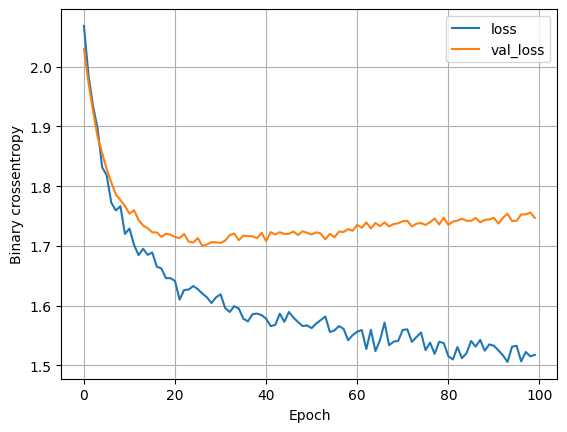

In [397]:
plot_history(history)